In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import os
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
color = sns.color_palette()
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 999

In [3]:
import numpy as np 
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

C:\Users\chino\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
train = pd.read_csv("mertrain.csv")
test = pd.read_csv("mertest.csv")

# process columns, apply LabelEncoder to categorical features
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder() 
        lbl.fit(list(train[c].values) + list(test[c].values)) 
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

# shape        
print('Shape train: {}\nShape test: {}'.format(train.shape, test.shape))

Shape train: (4209, 378)
Shape test: (4209, 377)


In [5]:
y = train['y'].values
y_mean = np.mean(y)
id_test = test['ID'].values
X = train.drop(['y','ID'], axis=1).values
X_test= test.drop(['ID'], axis=1).values

In [6]:
X = train.drop(['y'], axis=1).values

In [7]:
num_columns=X.shape[1]
num_columns

377

In [8]:
vifs=[variance_inflation_factor(X, i) for i in range(0, num_columns)]

C:\Users\chino\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\chino\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [9]:
from pandas import DataFrame
vif_df=DataFrame(vifs, index=train.drop(['y'], axis=1).columns, columns=['VIF'])
vif_df=vif_df.replace([np.inf, -np.inf], np.nan).dropna(how='all')
vif_df=vif_df.sort_values(ascending=False, by='VIF')


In [10]:
best_vif=[]
for i in list(vif_df.values):
    if i>=10:
        best_vif.append(i)

In [11]:
sig_vals=np.array(vif_df.index)
sig_vals

array(['X178', 'X362', 'X331', 'X49', 'X238', 'X129', 'X352', 'X179',
       'X215', 'X161', 'X103', 'X329', 'X328', 'X356', 'X246', 'X85',
       'X45', 'X367', 'X321', 'X256', 'X191', 'X358', 'X343', 'X355',
       'X150', 'X43', 'X312', 'X272', 'X2', 'X219', 'X57', 'X241', 'X234',
       'X197', 'X159', 'X65', 'X349', 'X223', 'X325', 'X87', 'X224',
       'X182', 'X100', 'X1', 'X114', 'X135', 'X357', 'X275', 'X294',
       'X361', 'X287', 'X148', 'X221', 'X327', 'X300', 'X350', 'X211',
       'X75', 'X78', 'X116', 'X69', 'X27', 'X47', 'X274', 'X81', 'X273',
       'X267', 'X351', 'X163', 'X70', 'X218', 'X68', 'X220', 'X50', 'X322',
       'X354', 'X3', 'X366', 'X51', 'X55', 'X0', 'X64', 'X210', 'X46',
       'X106', 'ID', 'X56', 'X82', 'X318', 'X5', 'X252', 'X153', 'X359',
       'X225', 'X384', 'X301', 'X212', 'X323', 'X79', 'X91', 'X231',
       'X206', 'X353', 'X151', 'X383', 'X141', 'X73', 'X38', 'X192',
       'X124', 'X6', 'X292', 'X8', 'X270', 'X291', 'X319', 'X104', 'X288',


In [12]:
vif_df.head()

,VIF
X178,1139.903769
X362,697.916906
X331,308.303315
X49,304.506282
X238,303.421330


In [13]:
vif_df_best=vif_df[vif_df.VIF>=10]
vif_best_index=vif_df_best.index

In [22]:
# pipelineでVIFで削除する特徴量の数のベストを探す。
r2_train=[]
r2_valid=[]
for i in np.arange(37):
    eliminate = vif_best_index[0:i]
    train_vif=train.drop(eliminate, axis=1)
    test_vif=test.drop(eliminate, axis=1)
    
    X = train_vif.drop(['y'], axis=1).values
    X_test= test_vif.values
    
    kf=KFold(n_splits=10, shuffle=True, random_state=0)
    kf.get_n_splits(X)
    
    for train_index, test_index in kf.split(X):
        X_train, y_train=X[train_index], y[train_index]
        X_valid, y_valid=X[test_index], y[test_index]
        
    model = RandomForestRegressor(n_estimators=100, random_state=0, max_depth=5)
    model.fit(X_train, y_train)
    
    
    r2_train.append(r2_score(y_train, model.predict(X_train)))
    r2_valid.append(r2_score(y_valid, model.predict(X_valid)))    

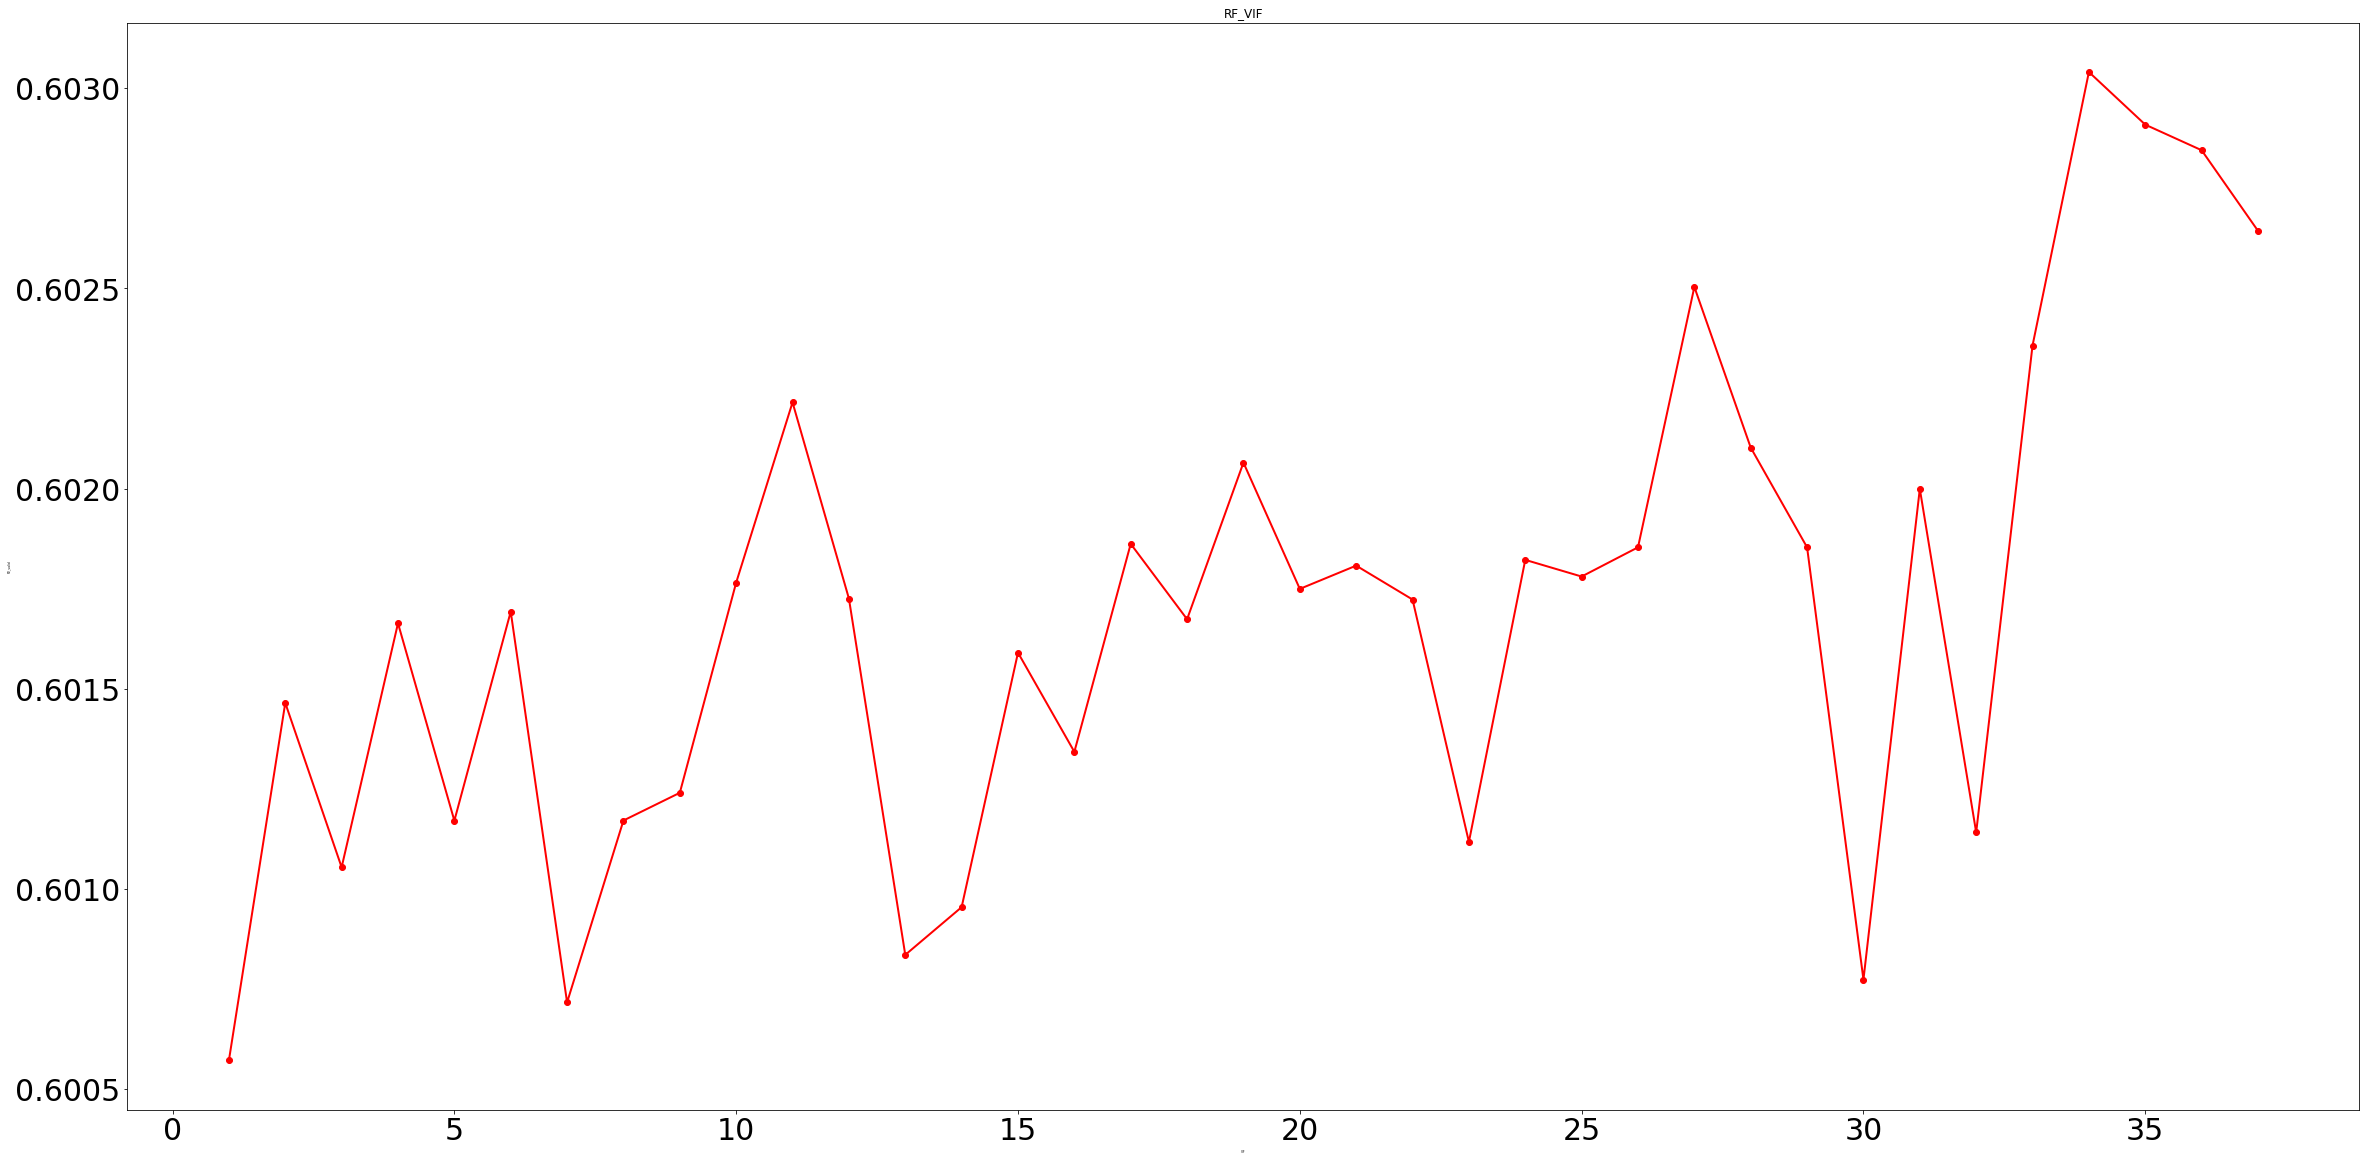

In [23]:
ig = plt.figure(figsize=(40,20))
sing_vals = np.arange(len(r2_valid) )+1
plt.plot(sing_vals, r2_valid, 'ro-', linewidth=2)
plt.title('RF_VIF')
plt.xlabel('VIF',fontsize=3)
plt.ylabel('R2_valid',fontsize=3)
plt.tick_params(labelsize=30)

plt.show()

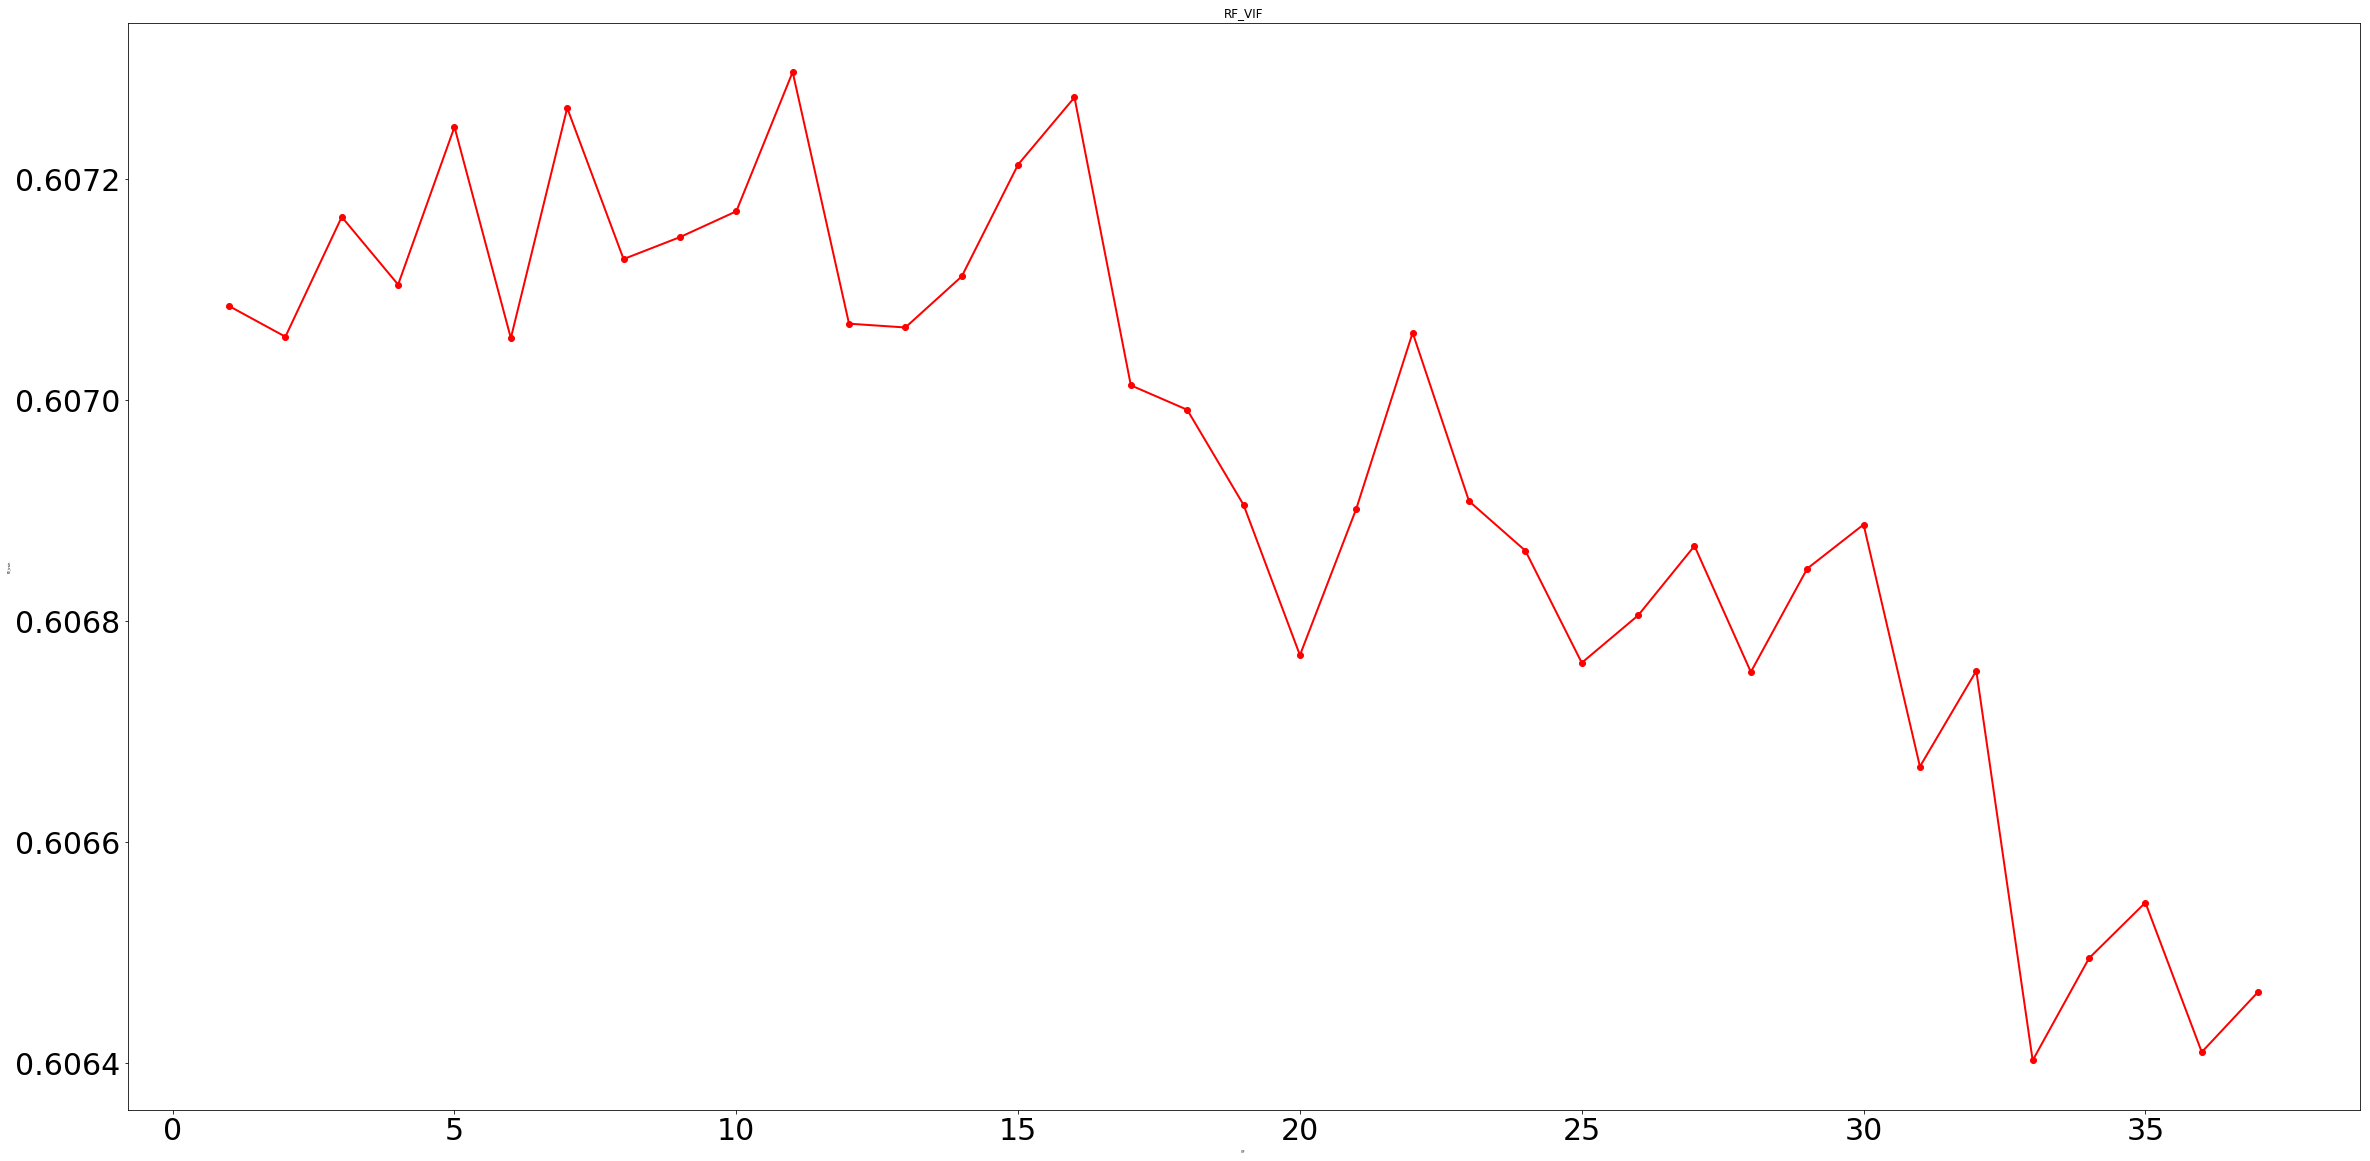

In [24]:
ig = plt.figure(figsize=(40,20))
sing_vals = np.arange(len(r2_train) )+1
plt.plot(sing_vals, r2_train, 'ro-', linewidth=2)
plt.title('RF_VIF')
plt.xlabel('VIF',fontsize=3)
plt.ylabel('R2_train',fontsize=3)
plt.tick_params(labelsize=30)

plt.show()

In [14]:
train_vif=train.drop(vif_best_index[0:27], axis=1)
test_vif=test.drop(vif_best_index[0:27], axis=1)

In [15]:
y = train_vif['y'].values
y_mean = np.mean(y)
id_test = test_vif['ID'].values
X = train_vif.drop(['y'], axis=1).values
X_test= test_vif.values

In [16]:
from sklearn.model_selection import KFold
kf=KFold(n_splits=10, shuffle=True, random_state=0)
kf.get_n_splits(X)

10

In [17]:
for train_index, test_index in kf.split(X):
    X_train, y_train=X[train_index], y[train_index]
    X_valid, y_valid=X[test_index], y[test_index]

In [19]:
model = RandomForestRegressor(n_estimators=500, random_state=0, max_depth=5)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [20]:
print(r2_score(y_train, model.predict(X_train)))
print(r2_score(y_valid, model.predict(X_valid)))

0.606557276827
0.600089620387


In [21]:
y_pred = model.predict(X_test)

In [22]:
sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = y_pred
sub.to_csv('randomforest_vif27.csv', index=False)
